In [1]:
import os
import scanpy as sc
import scanpy.external as sce
import numpy as np
from scipy import sparse
from scipy.spatial import distance_matrix
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
mpl.rcParams['font.size'] = 16

np.random.seed(1)

colormap_celltype = {"earlyNC":"#999999", "neural_glial":"#E69F00", "skeletal":"#56B4E9", "pigment": "#009E73", "unassigned":"#F0E442"}
celltype_colors = np.array( ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442"], str )
celltypes = ["earlyNC", "neural_glial", "skeletal", "pigment", "unassigned"]

In [2]:
ifname = "./data/WT/Arch1_new_aggregate_filtered_noNT.loom"
adata_orig = sc.read_loom(ifname)
adata_orig.X = adata_orig.layers["norm_data"]
X = adata_orig.X.copy()
X = X.expm1()
nCount_RNA = np.array( adata_orig.obs['nCount_RNA'] )
for i in range(X.shape[0]):
    X[i,:] *= nCount_RNA[i] / 10000.0
X = X.rint().astype(int)
adata_orig.layers['counts'] = X

/home/cang/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/cang/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'ClusterName' as categorical
... storing 'Phase' as categorical
... storing 'PigmentID' as categorical
... storing 'RNA_snn_res_0_4' as categorical
... storing 'RNA_snn_res_0_5' as categorical
... storing 'RNA_snn_res_1' as categorical
... storing 'orig_ident' as categorical
... storing 'seurat_clusters' as categorical


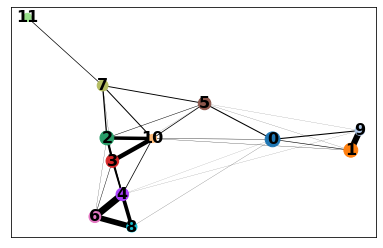

In [15]:
adata = adata_orig.copy()
n_pc = 50
n_top_genes = 2000
n_neighbors = 10
n_diffmap = 15
louvain_res = 1.0
random_seed = 1
celltypes_cellassign = np.array( pd.read_csv("./data/cellassign/celltypes.csv", index_col=0)['x'], str )
cellprobs_cellassign = np.array( pd.read_csv("./data/cellassign/cellprobs.csv", index_col=0), float )
for i in range(len(celltypes_cellassign)):
    if celltypes_cellassign[i] == 'other':
        celltypes_cellassign[i] = 'unassigned'
adata.obs['cellassign'] = pd.Series(celltypes_cellassign, index=adata.obs_names, dtype='category')

np.random.seed(random_seed)
sc.pp.recipe_zheng17(adata, n_top_genes=n_top_genes)
sc.tl.pca(adata, n_comps=n_pc)
sc.pp.neighbors(adata, n_neighbors=n_neighbors)
sc.tl.diffmap(adata, n_comps=n_diffmap)
sc.tl.louvain(adata, resolution=louvain_res)
sc.tl.paga(adata)    
sc.pl.paga(adata, threshold=0.01, layout='fr', show=False)
adata.uns['iroot'] = np.where(adata.obs.index == "AAACCTGAGTGGCACA-1")[0][0]
sc.tl.dpt(adata, n_dcs = min(adata.obsm["X_diffmap"].shape[1], 10))
sc.tl.draw_graph(adata, init_pos='paga')

### **individual branches**

In [26]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel as C
import seaborn as sns
sns.set_theme(style="white")

In [6]:
df_ms_progression = pd.read_csv("./data/simplified_progressions.csv", index_col=0)
x_dendro = []
for cellid in adata_orig.obs_names:
    ms = df_ms_progression.loc[df_ms_progression['cell_id']==cellid,['from','to']].values[0]
    percent = df_ms_progression.loc[df_ms_progression['cell_id']==cellid,['percentage']].values[0][0]
    if ms[0] == 2 and ms[1] == 7:
        tmp_pt = [percent, 0]
    elif ms[0] == 7 and ms[1] == 13:
        tmp_pt = [percent+1.0, 2]
    elif ms[0] == 7 and ms[1] == 3:
        tmp_pt = [percent+1.0, -1]
    elif ms[0] == 3 and ms[1] == 12:
        tmp_pt = [percent+2.0, 0]
    elif ms[0] == 3 and ms[1] == 10:
        tmp_pt = [0.25*percent+2.0, -2]
    x_dendro.append(tmp_pt)
x_dendro = np.array(x_dendro)
x_dendro[:,1] += 0.15 * np.random.normal(size=1284)

In [8]:
cellnames = np.array(adata_orig.obs_names)
# branch 1 (pigment)
idx_branch_1 = []
# branch 2 (skeletal)
idx_branch_2 = []
# branch 3 (neural_glial)
idx_branch_3 = []
for i in range(1284):
    cell_id = cellnames[i]
    ms = df_ms_progression.loc[df_ms_progression['cell_id']==cell_id,['from','to']].values[0]
    if (ms[0] == 2 and ms[1] == [7]) or (ms[0] == 7 and ms[1] == 13):
        idx_branch_1.append(i)
    if (ms[0] == 2 and ms[1] == [7]) or (ms[0] == 7 and ms[1] == [3]) or (ms[0] == 3 and ms[1] == [12]):
        idx_branch_2.append(i)
    if (ms[0] == 2 and ms[1] == [7]) or (ms[0] == 7 and ms[1] == [3]) or (ms[0] == 3 and ms[1] == [10]):
        idx_branch_3.append(i)
idx_branch_1 = np.array(idx_branch_1, int)
idx_branch_2 = np.array(idx_branch_2, int)
idx_branch_3 = np.array(idx_branch_3, int)

In [3]:
from typing import Optional, Union
import sys
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import networkx as nx
from matplotlib import cm
import matplotlib.pyplot as plt
import plotly
from scipy import sparse
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr
from sklearn.preprocessing import normalize
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA

def deg_detection(
    adata: anndata.AnnData,
    cofactor,
    n_var_genes: int = 3000,
    nknots: int = 6,
    n_deg_genes: int = None,
    n_points: int = 50,
    deg_pvalue_cutoff: float = 0.05,
):

    # setup R environment
    import rpy2
    import anndata2ri
    import rpy2.robjects as ro
    from rpy2.robjects.conversion import localconverter
    import rpy2.rinterface_lib.callbacks
    import logging
    rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

    ro.r('library(tradeSeq)')
    ro.r('library(clusterExperiment)')
    anndata2ri.activate()
    ro.numpy2ri.activate()
    ro.pandas2ri.activate()

    # prepare input adata for R
    adata_deg = anndata.AnnData(
        X = adata.layers['counts'],
        var = pd.DataFrame(index=list(adata.var_names)),
        obs = pd.DataFrame(index=list(adata.obs_names)))
    adata_deg_var = adata_deg.copy()
    sc.pp.normalize_total(adata_deg_var)
    sc.pp.log1p(adata_deg_var)
    sc.pp.highly_variable_genes(adata_deg_var, n_top_genes=n_var_genes)
    adata_deg = adata_deg[:, adata_deg_var.var.highly_variable]
    del adata_deg_var

    cell_weight = np.ones_like(cofactor).reshape(-1,1)

    # send adata to R
    adata_r = anndata2ri.py2rpy(adata_deg)
    ro.r.assign("adata", adata_r)
    ro.r("X <- as.matrix( assay( adata, 'X') )")
    ro.r.assign("pseudoTime", cofactor)
    ro.r.assign("cellWeight", cell_weight)

    # perform analysis (tradeSeq-1.0.1 in R-3.6.3)
    string_fitGAM = 'sce <- fitGAM(counts=X, pseudotime=pseudoTime[,1], cellWeights=cellWeight[,1], nknots=%d, verbose=TRUE)' % nknots
    ro.r(string_fitGAM)
    ro.r('assoRes <- data.frame( associationTest(sce, global=FALSE, lineage=TRUE) )')
    ro.r('assoRes[is.nan(assoRes[,"waldStat_1"]),"waldStat_1"] <- 0.0')
    ro.r('assoRes[is.nan(assoRes[,"df_1"]),"df_1"] <- 0.0')
    ro.r('assoRes[is.nan(assoRes[,"pvalue_1"]),"pvalue_1"] <- 1.0')
    with localconverter(ro.pandas2ri.converter):
        df_assoRes = ro.r['assoRes']
    ro.r('assoRes = assoRes[assoRes[,"pvalue_1"] <= %f,]' % deg_pvalue_cutoff)
    ro.r('oAsso <- order(assoRes[,"waldStat_1"], decreasing=TRUE)')
    if n_deg_genes is None:
        n_deg_genes = df_assoRes.shape[0]
    string_cluster = 'clusPat <- clusterExpressionPatterns(sce, nPoints = %d,' % n_points\
        + 'verbose=TRUE, genes = rownames(assoRes)[oAsso][1:min(%d,length(oAsso))],' % n_deg_genes \
        + ' k0s=4:5, alphas=c(0.1))'
    ro.r(string_cluster)
    ro.r('yhatScaled <- data.frame(clusPat$yhatScaled)')
    with localconverter(ro.pandas2ri.converter):
        yhat_scaled = ro.r['yhatScaled']

    df_deg = df_assoRes.rename(columns={'waldStat_1':'waldStat', 'df_1':'df', 'pvalue_1':'pvalue'})
    idx = np.argsort(-df_deg['waldStat'].values)
    df_deg = df_deg.iloc[idx]
    df_yhat = yhat_scaled

    anndata2ri.deactivate()
    ro.numpy2ri.deactivate()
    ro.pandas2ri.deactivate()

    return df_deg, df_yhat

def order_deg_genes(
    df_deg,
    df_yhat,
    top_ngene = 500,
    p_value_cutoff = 0.05
):
    pvalue = df_deg['pvalue'].values
#     wald_stats = df_deg['waldStat'].values
    
    tmp_idx = np.where(pvalue < p_value_cutoff)[0]
    df_deg = df_deg.iloc[tmp_idx]
    tmp_genes = list(set(df_deg.index).intersection(set(df_yhat.index)))
    df_yhat = df_yhat.loc[tmp_genes]
    df_deg = df_deg.loc[tmp_genes]
    if not top_ngene is None:
        tmp_idx = np.argsort(-df_deg['waldStat'].values)[:top_ngene]
        df_deg_tmp = df_deg.iloc[tmp_idx]
    else:
        df_deg_tmp = df_deg
    df_yhat_tmp = df_yhat.loc[df_deg_tmp.index]
    weighted_loc = []
    for i in range(df_deg_tmp.shape[0]):
        yhat_tmp = np.array( df_yhat_tmp.iloc[i].values ).reshape(-1)
        yhat_tmp_exp = np.exp(yhat_tmp) / np.exp(yhat_tmp.max())
#         loc = np.sum( np.arange(yhat_tmp.shape[0]) * yhat_tmp_exp ) / np.sum(yhat_tmp_exp)
#         peak_loc = np.argmax(yhat_tmp)
        loc = np.min(np.where(yhat_tmp > 0.0))
        weighted_loc.append(loc)
    idx = np.argsort(-np.array( weighted_loc) )
    return df_deg_tmp.iloc[idx], df_yhat_tmp.iloc[idx]

In [9]:
df_deg_pigment, df_yhat_pigment = deg_detection(adata_orig[idx_branch_1,:], x_dendro[idx_branch_1,0].reshape(-1,1), n_var_genes=3000, n_deg_genes=1000)

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~04m 28s       |+                                                 | 2 % ~14m 23s       |++                                                | 3 % ~10m 59s       |++                                                | 4 % ~16m 52s       |+++                                               | 5 % ~17m 27s       |+++                                               | 6 % ~15m 38s       |++++                                              | 7 % ~14m 22s       |++++                                              | 8 % ~14m 03s       |+++++                                             | 9 % ~13m 00s       |+++++                                             | 10% ~12m 11s       |++++++                                            | 11% ~11m 25s       |++++++                                            | 12% ~11m 06s       |+++++++                                           | 13% ~11m 

In [10]:
df_deg_skeletal, df_yhat_skeletal = deg_detection(adata_orig[idx_branch_2,:], x_dendro[idx_branch_2,0].reshape(-1,1), n_var_genes=3000, n_deg_genes=1000)

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~27m 48s       |+                                                 | 2 % ~15m 10s       |++                                                | 3 % ~15m 30s       |++                                                | 4 % ~13m 56s       |+++                                               | 5 % ~13m 17s       |+++                                               | 6 % ~11m 20s       |++++                                              | 7 % ~13m 32s       |++++                                              | 8 % ~13m 08s       |+++++                                             | 9 % ~12m 08s       |+++++                                             | 10% ~11m 06s       |++++++                                            | 11% ~11m 07s       |++++++                                            | 12% ~11m 07s       |+++++++                                           | 13% ~10m 

In [11]:
df_deg_pigment.to_csv("./data/df_deg_pigment.csv")
df_yhat_pigment.to_csv("./data/df_yhat_pigment.csv")
df_deg_skeletal.to_csv("./data/df_deg_skeletal.csv")
df_yhat_skeletal.to_csv("./data/df_yhat_skeletal.csv")

In [12]:
df_deg_pigment = pd.read_csv("./data/df_deg_pigment.csv", index_col=0)
df_yhat_pigment = pd.read_csv("./data/df_yhat_pigment.csv", index_col=0)
df_deg_skeletal = pd.read_csv("./data/df_deg_skeletal.csv", index_col=0)
df_yhat_skeletal = pd.read_csv("./data/df_yhat_skeletal.csv", index_col=0)

In [13]:
df_deg_skeletal_ordered, df_yhat_skeletal_ordered = order_deg_genes(df_deg_skeletal, df_yhat_skeletal, top_ngene = 500)

13


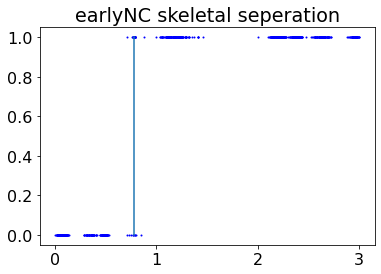

21


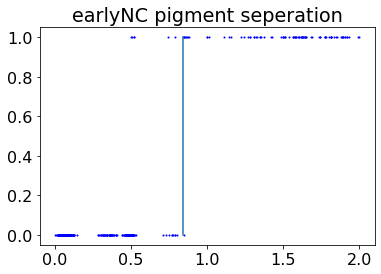

In [16]:
from sklearn.metrics import balanced_accuracy_score
x_tmp = x_dendro[idx_branch_2,0]
celltypes_array = np.array( adata.obs['cellassign'], str )
c_tmp = np.empty([x_tmp.shape[0]])
for i in range(len(idx_branch_2)):
    if celltypes_array[idx_branch_2[i]] == 'earlyNC':
        c_tmp[i] = 0
    elif celltypes_array[idx_branch_2[i]] == 'skeletal':
        c_tmp[i] = 1
    else:
        c_tmp[i] = 2
idx_tmp = np.where(c_tmp != 2)[0]
x_tmp = x_tmp[idx_tmp]
c_tmp = c_tmp[idx_tmp]
best_t = 0
current_score = 0
for i in range(50):
    c_pred = np.ones_like(c_tmp)
    c_pred[np.where(x_tmp < i / 50.0 * 3.0)[0]] = 0
    score = balanced_accuracy_score(c_tmp, c_pred)
    if score > current_score:
        best_t = i
        current_score = score
plt.scatter(x_tmp, c_tmp, c='b', s=1)
best_t = 13
plt.plot([best_t / 50 * 3.0, best_t / 50 * 3.0], [0,1])
plt.title("earlyNC skeletal seperation")
print(best_t)
plt.show()


x_tmp = x_dendro[idx_branch_1,0]
celltypes_array = np.array( adata.obs['cellassign'], str )
c_tmp = np.empty([x_tmp.shape[0]])
for i in range(len(idx_branch_1)):
    if celltypes_array[idx_branch_1[i]] == 'earlyNC':
        c_tmp[i] = 0
    elif celltypes_array[idx_branch_1[i]] == 'pigment':
        c_tmp[i] = 1
    else:
        c_tmp[i] = 2
idx_tmp = np.where(c_tmp != 2)[0]
x_tmp = x_tmp[idx_tmp]
c_tmp = c_tmp[idx_tmp]
best_t = 0
current_score = 0
for i in range(50):
    c_pred = np.ones_like(c_tmp)
    c_pred[np.where(x_tmp < i / 50.0 * 2.0)[0]] = 0
    score = balanced_accuracy_score(c_tmp, c_pred)
    if score > current_score:
        best_t = i
        current_score = score
plt.scatter(x_tmp, c_tmp, c='b', s=1)
plt.plot([best_t / 50 * 2.0, best_t / 50 * 2.0], [0,1])
plt.title("earlyNC pigment seperation")
print(best_t)
plt.show()

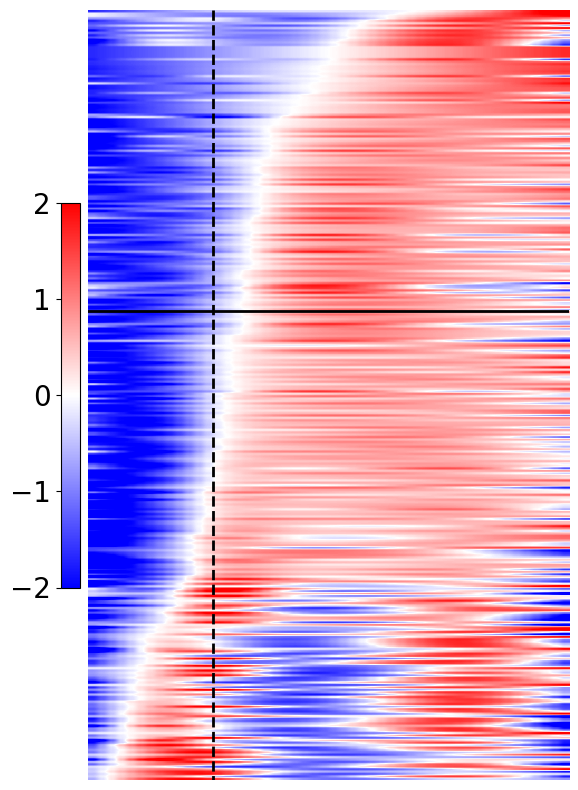

In [17]:
plt.rcdefaults()
mpl.rcParams['font.size'] = 20

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(df_yhat_skeletal_ordered.iloc[:320], extent=[0,200,320,0], cmap='bwr', vmax=2, vmin=-2)
ax.plot([130 * 2 / 5,130 * 2 / 5],[0,320],'k--', linewidth=2)
ax.plot([0,200],[125,125],'k', linewidth=2)
# ax.plot([0,500],[320,320],'k', linewidth=2)

plt.colorbar(im, shrink=0.5, location='left',pad=0.01)
ax.axis('off')
plt.savefig("./figures/heatmap_deg_skeletal_branch.pdf")

In [18]:
df_deg_pigment_ordered, df_yhat_pigment_ordered = order_deg_genes(df_deg_pigment, df_yhat_pigment, top_ngene=500)

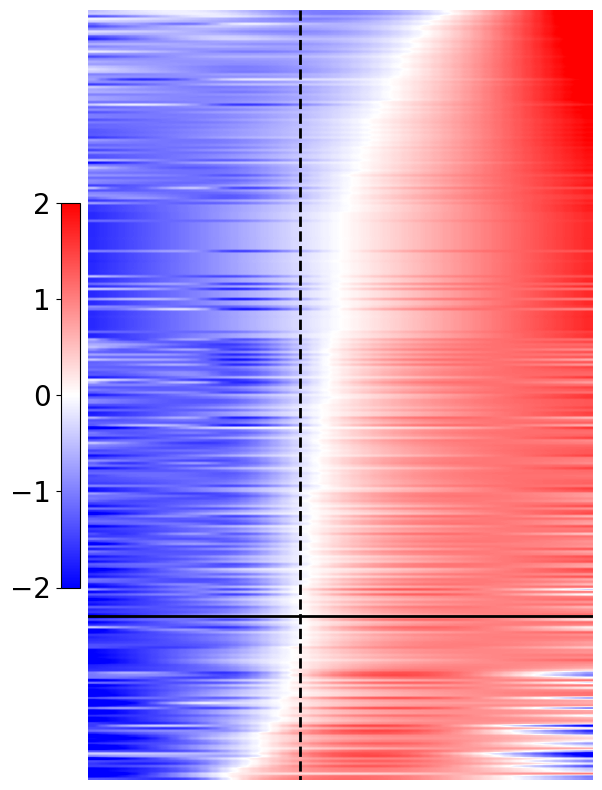

In [19]:
mpl.rcParams['font.size'] = 20

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(df_yhat_pigment_ordered.iloc[:305], extent=[0,200,305,0], cmap='bwr', vmax=2, vmin=-2)
ax.plot([210 * 2 / 5,210 * 2 / 5],[0,305],'k--', linewidth=2)
ax.plot([0,200],[240,240],'k', linewidth=2)
# ax.plot([0,500],[305,305],'k', linewidth=2)

plt.colorbar(im, shrink=0.5, location='left',pad=0.01)
ax.axis('off')
plt.savefig("./figures/heatmap_deg_pigment_branch.pdf")

In [20]:
early_pigment_genes = list( df_deg_pigment_ordered.index[240:305] )
early_skeletal_genes = list( df_deg_skeletal_ordered.index[125:320] )

In [21]:
late_skeletal_genes = list( df_deg_skeletal_ordered.index[:125] )
late_pigment_genes = list( df_deg_pigment_ordered.index[:240] )

In [22]:
gm_pigment_exp = np.mean(adata_orig[:, early_pigment_genes].X.toarray(), axis=1)
gm_skeletal_exp = np.mean(adata_orig[:, early_skeletal_genes].X.toarray(), axis=1)
gm_pigment_late_exp = np.mean(adata_orig[:, late_pigment_genes].X.toarray(), axis=1)
gm_skeletal_late_exp = np.mean(adata_orig[:, late_skeletal_genes].X.toarray(), axis=1)

In [23]:
celltypes_array = np.array( adata.obs['cellassign'], str )

In [24]:
idx_earlync = np.where(celltypes_array == 'earlyNC')[0]
idx_pigment = np.where(celltypes_array == 'pigment')[0]
idx_skeletal = np.where(celltypes_array == 'skeletal')[0]

In [27]:
# skeletal early
kernel = C(.1, (1e-3, .1)) * Matern(length_scale=1.0, length_scale_bounds=(2,4), nu=2.5) \
    + WhiteKernel(noise_level=0.05, noise_level_bounds=(0.01,0.1))
gp_sk_e_pg = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.0)
gp_sk_e_pg.fit(x_dendro[idx_branch_1,0].reshape(-1,1), gm_skeletal_exp[idx_branch_1].reshape(-1,1))

kernel = C(.1, (1e-3, .1)) * Matern(length_scale=1.0, length_scale_bounds=(2,4), nu=2.5) \
    + WhiteKernel(noise_level=0.05, noise_level_bounds=(0.01,0.1))
gp_sk_e_sk = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.0)
gp_sk_e_sk.fit(x_dendro[idx_branch_2,0].reshape(-1,1), gm_skeletal_exp[idx_branch_2].reshape(-1,1))

/home/cang/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/cang/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 2. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/cang/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value

GaussianProcessRegressor(alpha=0.0,
                         kernel=0.316**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.05),
                         n_restarts_optimizer=9)

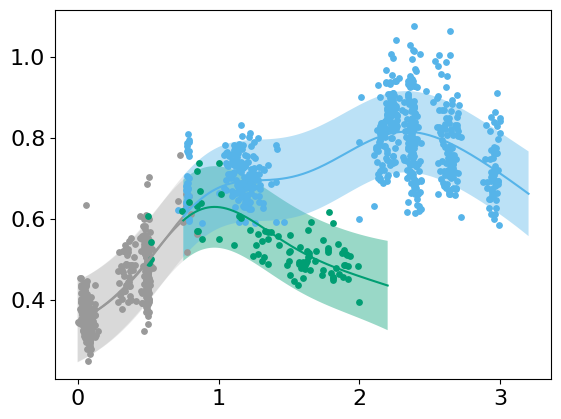

In [29]:
# skeletal early
plt.rcdefaults()
mpl.rcParams['font.size'] = 16
fig, ax1 = plt.subplots()

x_mesh = np.atleast_2d(np.linspace(0, 0.75, 200)).T
y_pred, sigma = gp_sk_e_pg.predict(x_mesh, return_std=True)
y_pred = y_pred.reshape(-1)
ax1.plot(x_mesh, y_pred, color=colormap_celltype["earlyNC"])
ax1.fill_between(x_mesh.reshape(-1), (y_pred-sigma).reshape(-1), (y_pred+sigma).reshape(-1),
        alpha=0.2, ec="None", fc=colormap_celltype["earlyNC"])

x_mesh = np.atleast_2d(np.linspace(0.75, 2.2, 200)).T
y_pred, sigma = gp_sk_e_pg.predict(x_mesh, return_std=True)
y_pred = y_pred.reshape(-1)
ax1.plot(x_mesh, y_pred, color=colormap_celltype["pigment"])
ax1.fill_between(x_mesh.reshape(-1), (y_pred-sigma).reshape(-1), (y_pred+sigma).reshape(-1),
        alpha=0.4, ec="None", fc=colormap_celltype["pigment"])
# ax1.scatter(x_dendro[idx_branch_1,0], mrk_exp_pg[idx_branch_1], s=2, c=colormap_celltype["pigment"], label="pigment genes")
# ax1.set_ylabel('pigment genes', color=colormap_celltype["pigment"])
# ax1.tick_params(axis='y', labelcolor=colormap_celltype["pigment"])

x_mesh = np.atleast_2d(np.linspace(0, 0.75, 200)).T
y_pred, sigma = gp_sk_e_sk.predict(x_mesh, return_std=True)
y_pred = y_pred.reshape(-1)
ax1.plot(x_mesh, y_pred, color=colormap_celltype["earlyNC"])
ax1.fill_between(x_mesh.reshape(-1), (y_pred-sigma).reshape(-1), (y_pred+sigma).reshape(-1),
        alpha=0.2, ec="None", fc=colormap_celltype["earlyNC"])

x_mesh = np.atleast_2d(np.linspace(0.75, 3.2, 200)).T
y_pred, sigma = gp_sk_e_sk.predict(x_mesh, return_std=True)
y_pred = y_pred.reshape(-1)
ax1.plot(x_mesh, y_pred, color=colormap_celltype["skeletal"])
ax1.fill_between(x_mesh.reshape(-1), (y_pred-sigma).reshape(-1), (y_pred+sigma).reshape(-1),
        alpha=0.4, ec="None", fc=colormap_celltype["skeletal"])
# ax1.scatter(x_dendro[idx_branch_1,0], mrk_exp_nc[idx_branch_1], s=2, c=colormap_celltype["earlyNC"], label="earlyNC genes")
# ax1.set_ylabel('earlyNC genes', color=colormap_celltype["skeletal"])
# ax1.tick_params(axis='y', labelcolor=colormap_celltype["skeletal"])

ax1.scatter(x_dendro[idx_earlync,0], gm_skeletal_exp[idx_earlync], c = colormap_celltype['earlyNC'], s=15)
ax1.scatter(x_dendro[idx_skeletal,0], gm_skeletal_exp[idx_skeletal], c=colormap_celltype['skeletal'], s=15)
ax1.scatter(x_dendro[idx_pigment,0], gm_skeletal_exp[idx_pigment], c=colormap_celltype['pigment'], s=15)

# ax1.legend(loc=[1.1,0.1], markerscale=5)
# ax2.legend(loc=[1.1,0], markerscale=5)
plt.savefig("./figures/gpr_skeletal_early_genes.pdf", bbox_inches='tight')

In [30]:
# skeletal late
kernel = C(.1, (1e-3, .1)) * Matern(length_scale=1.0, length_scale_bounds=(2,4), nu=2.5) \
    + WhiteKernel(noise_level=0.05, noise_level_bounds=(0.01,0.1))
gp_sk_l_pg = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.0)
gp_sk_l_pg.fit(x_dendro[idx_branch_1,0].reshape(-1,1), gm_skeletal_late_exp[idx_branch_1].reshape(-1,1))

kernel = C(.1, (1e-3, .1)) * Matern(length_scale=1.0, length_scale_bounds=(2,4), nu=2.5) \
    + WhiteKernel(noise_level=0.05, noise_level_bounds=(0.01,0.1))
gp_sk_l_sk = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.0)
gp_sk_l_sk.fit(x_dendro[idx_branch_2,0].reshape(-1,1), gm_skeletal_late_exp[idx_branch_2].reshape(-1,1))

/home/cang/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/cang/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/cang/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal v

GaussianProcessRegressor(alpha=0.0,
                         kernel=0.316**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.05),
                         n_restarts_optimizer=9)

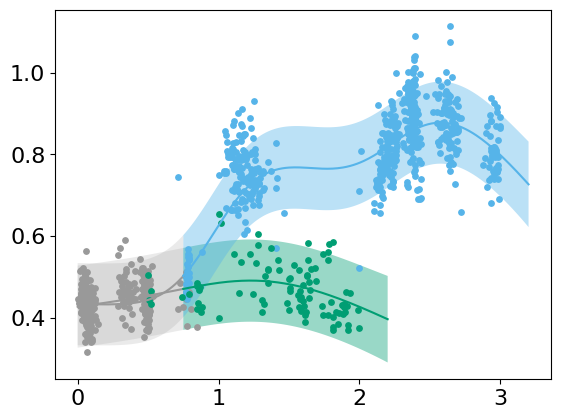

In [31]:
# skeletal late
fig, ax1 = plt.subplots()

x_mesh = np.atleast_2d(np.linspace(0, 0.75, 200)).T
y_pred, sigma = gp_sk_l_pg.predict(x_mesh, return_std=True)
y_pred = y_pred.reshape(-1)
ax1.plot(x_mesh, y_pred, color=colormap_celltype["earlyNC"])
ax1.fill_between(x_mesh.reshape(-1), (y_pred-sigma).reshape(-1), (y_pred+sigma).reshape(-1),
        alpha=0.2, ec="None", fc=colormap_celltype["earlyNC"])

x_mesh = np.atleast_2d(np.linspace(0.75, 2.2, 200)).T
y_pred, sigma = gp_sk_l_pg.predict(x_mesh, return_std=True)
y_pred = y_pred.reshape(-1)
ax1.plot(x_mesh, y_pred, color=colormap_celltype["pigment"])
ax1.fill_between(x_mesh.reshape(-1), (y_pred-sigma).reshape(-1), (y_pred+sigma).reshape(-1),
        alpha=0.4, ec="None", fc=colormap_celltype["pigment"])
# ax1.scatter(x_dendro[idx_branch_1,0], mrk_exp_pg[idx_branch_1], s=2, c=colormap_celltype["pigment"], label="pigment genes")
# ax1.set_ylabel('pigment genes', color=colormap_celltype["pigment"])
# ax1.tick_params(axis='y', labelcolor=colormap_celltype["pigment"])

x_mesh = np.atleast_2d(np.linspace(0, 0.75, 200)).T
y_pred, sigma = gp_sk_l_sk.predict(x_mesh, return_std=True)
y_pred = y_pred.reshape(-1)
ax1.plot(x_mesh, y_pred, color=colormap_celltype["earlyNC"])
ax1.fill_between(x_mesh.reshape(-1), (y_pred-sigma).reshape(-1), (y_pred+sigma).reshape(-1),
        alpha=0.2, ec="None", fc=colormap_celltype["earlyNC"])

x_mesh = np.atleast_2d(np.linspace(0.75, 3.2, 200)).T
y_pred, sigma = gp_sk_l_sk.predict(x_mesh, return_std=True)
y_pred = y_pred.reshape(-1)
ax1.plot(x_mesh, y_pred, color=colormap_celltype["skeletal"])
ax1.fill_between(x_mesh.reshape(-1), (y_pred-sigma).reshape(-1), (y_pred+sigma).reshape(-1),
        alpha=0.4, ec="None", fc=colormap_celltype["skeletal"])
# ax1.scatter(x_dendro[idx_branch_1,0], mrk_exp_nc[idx_branch_1], s=2, c=colormap_celltype["earlyNC"], label="earlyNC genes")
# ax1.set_ylabel('earlyNC genes', color=colormap_celltype["skeletal"])
# ax1.tick_params(axis='y', labelcolor=colormap_celltype["skeletal"])

ax1.scatter(x_dendro[idx_earlync,0], gm_skeletal_late_exp[idx_earlync], c = colormap_celltype['earlyNC'], s=15)
ax1.scatter(x_dendro[idx_skeletal,0], gm_skeletal_late_exp[idx_skeletal], c=colormap_celltype['skeletal'], s=15)
ax1.scatter(x_dendro[idx_pigment,0], gm_skeletal_late_exp[idx_pigment], c=colormap_celltype['pigment'], s=15)

# ax1.legend(loc=[1.1,0.1], markerscale=5)
# ax2.legend(loc=[1.1,0], markerscale=5)
plt.savefig("./figures/gpr_skeletal_late_genes.pdf", bbox_inches='tight')

In [32]:
# pigment early
kernel = C(.1, (1e-3, .1)) * Matern(length_scale=1.0, length_scale_bounds=(2,4), nu=2.5) \
    + WhiteKernel(noise_level=0.05, noise_level_bounds=(0.01,0.1))
gp_pg_e_pg = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.0)
gp_pg_e_pg.fit(x_dendro[idx_branch_1,0].reshape(-1,1), gm_pigment_exp[idx_branch_1].reshape(-1,1))

kernel = C(.1, (1e-3, .1)) * Matern(length_scale=1.0, length_scale_bounds=(2,4), nu=2.5) \
    + WhiteKernel(noise_level=0.05, noise_level_bounds=(0.01,0.1))
gp_pg_e_sk = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.0)
gp_pg_e_sk.fit(x_dendro[idx_branch_2,0].reshape(-1,1), gm_pigment_exp[idx_branch_2].reshape(-1,1))

/home/cang/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/cang/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 2. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/cang/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value

GaussianProcessRegressor(alpha=0.0,
                         kernel=0.316**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.05),
                         n_restarts_optimizer=9)

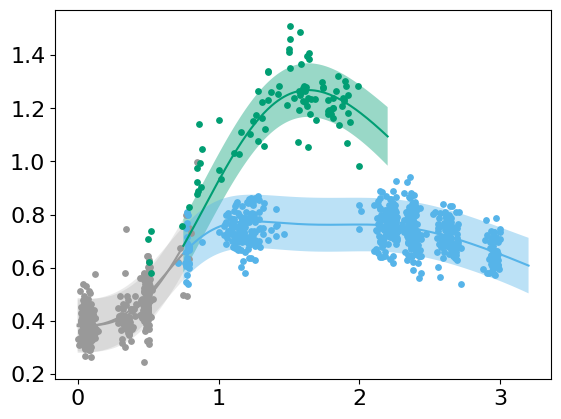

In [33]:
# pigment early
plt.rcdefaults()
mpl.rcParams['font.size'] = 16
fig, ax1 = plt.subplots()

x_mesh = np.atleast_2d(np.linspace(0, 0.75, 200)).T
y_pred, sigma = gp_pg_e_pg.predict(x_mesh, return_std=True)
y_pred = y_pred.reshape(-1)
ax1.plot(x_mesh, y_pred, color=colormap_celltype["earlyNC"])
ax1.fill_between(x_mesh.reshape(-1), (y_pred-sigma).reshape(-1), (y_pred+sigma).reshape(-1),
        alpha=0.2, ec="None", fc=colormap_celltype["earlyNC"])

x_mesh = np.atleast_2d(np.linspace(0.75, 2.2, 200)).T
y_pred, sigma = gp_pg_e_pg.predict(x_mesh, return_std=True)
y_pred = y_pred.reshape(-1)
ax1.plot(x_mesh, y_pred, color=colormap_celltype["pigment"])
ax1.fill_between(x_mesh.reshape(-1), (y_pred-sigma).reshape(-1), (y_pred+sigma).reshape(-1),
        alpha=0.4, ec="None", fc=colormap_celltype["pigment"])
# ax1.scatter(x_dendro[idx_branch_1,0], mrk_exp_pg[idx_branch_1], s=2, c=colormap_celltype["pigment"], label="pigment genes")
# ax1.set_ylabel('pigment genes', color=colormap_celltype["pigment"])
# ax1.tick_params(axis='y', labelcolor=colormap_celltype["pigment"])

x_mesh = np.atleast_2d(np.linspace(0, 0.75, 200)).T
y_pred, sigma = gp_pg_e_sk.predict(x_mesh, return_std=True)
y_pred = y_pred.reshape(-1)
ax1.plot(x_mesh, y_pred, color=colormap_celltype["earlyNC"])
ax1.fill_between(x_mesh.reshape(-1), (y_pred-sigma).reshape(-1), (y_pred+sigma).reshape(-1),
        alpha=0.2, ec="None", fc=colormap_celltype["earlyNC"])

x_mesh = np.atleast_2d(np.linspace(0.75, 3.2, 200)).T
y_pred, sigma = gp_pg_e_sk.predict(x_mesh, return_std=True)
y_pred = y_pred.reshape(-1)
ax1.plot(x_mesh, y_pred, color=colormap_celltype["skeletal"])
ax1.fill_between(x_mesh.reshape(-1), (y_pred-sigma).reshape(-1), (y_pred+sigma).reshape(-1),
        alpha=0.4, ec="None", fc=colormap_celltype["skeletal"])
# ax1.scatter(x_dendro[idx_branch_1,0], mrk_exp_nc[idx_branch_1], s=2, c=colormap_celltype["earlyNC"], label="earlyNC genes")
# ax1.set_ylabel('earlyNC genes', color=colormap_celltype["skeletal"])
# ax1.tick_params(axis='y', labelcolor=colormap_celltype["skeletal"])

ax1.scatter(x_dendro[idx_earlync,0], gm_pigment_exp[idx_earlync], c = colormap_celltype['earlyNC'], s=15)
ax1.scatter(x_dendro[idx_skeletal,0], gm_pigment_exp[idx_skeletal], c=colormap_celltype['skeletal'], s=15)
ax1.scatter(x_dendro[idx_pigment,0], gm_pigment_exp[idx_pigment], c=colormap_celltype['pigment'], s=15)

# ax1.legend(loc=[1.1,0.1], markerscale=5)
# ax2.legend(loc=[1.1,0], markerscale=5)
plt.savefig("./figures/gpr_pigment_early_genes.pdf", bbox_inches='tight')

In [34]:
# pigment late
kernel = C(.1, (1e-3, .1)) * Matern(length_scale=1.0, length_scale_bounds=(2,4), nu=2.5) \
    + WhiteKernel(noise_level=0.05, noise_level_bounds=(0.01,0.1))
gp_pg_l_pg = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.0)
gp_pg_l_pg.fit(x_dendro[idx_branch_1,0].reshape(-1,1), gm_pigment_late_exp[idx_branch_1].reshape(-1,1))

kernel = C(.1, (1e-3, .1)) * Matern(length_scale=1.0, length_scale_bounds=(2,4), nu=2.5) \
    + WhiteKernel(noise_level=0.05, noise_level_bounds=(0.01,0.1))
gp_pg_l_sk = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.0)
gp_pg_l_sk.fit(x_dendro[idx_branch_2,0].reshape(-1,1), gm_pigment_late_exp[idx_branch_2].reshape(-1,1))

/home/cang/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/cang/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 2. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/cang/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value

GaussianProcessRegressor(alpha=0.0,
                         kernel=0.316**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.05),
                         n_restarts_optimizer=9)

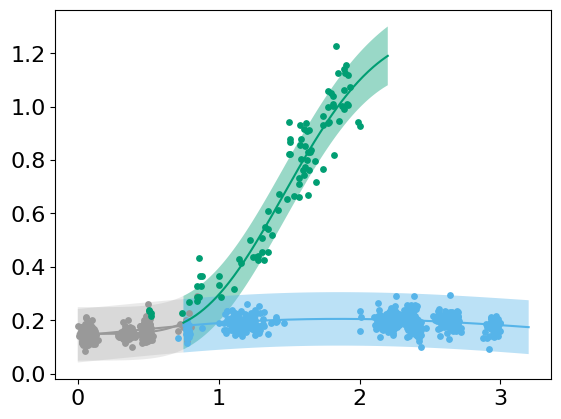

In [35]:
# pigment late
plt.rcdefaults()
mpl.rcParams['font.size'] = 16
fig, ax1 = plt.subplots()

x_mesh = np.atleast_2d(np.linspace(0, 0.75, 200)).T
y_pred, sigma = gp_pg_l_pg.predict(x_mesh, return_std=True)
y_pred = y_pred.reshape(-1)
ax1.plot(x_mesh, y_pred, color=colormap_celltype["earlyNC"])
ax1.fill_between(x_mesh.reshape(-1), (y_pred-sigma).reshape(-1), (y_pred+sigma).reshape(-1),
        alpha=0.2, ec="None", fc=colormap_celltype["earlyNC"])

x_mesh = np.atleast_2d(np.linspace(0.75, 2.2, 200)).T
y_pred, sigma = gp_pg_l_pg.predict(x_mesh, return_std=True)
y_pred = y_pred.reshape(-1)
ax1.plot(x_mesh, y_pred, color=colormap_celltype["pigment"])
ax1.fill_between(x_mesh.reshape(-1), (y_pred-sigma).reshape(-1), (y_pred+sigma).reshape(-1),
        alpha=0.4, ec="None", fc=colormap_celltype["pigment"])
# ax1.scatter(x_dendro[idx_branch_1,0], mrk_exp_pg[idx_branch_1], s=2, c=colormap_celltype["pigment"], label="pigment genes")
# ax1.set_ylabel('pigment genes', color=colormap_celltype["pigment"])
# ax1.tick_params(axis='y', labelcolor=colormap_celltype["pigment"])

x_mesh = np.atleast_2d(np.linspace(0, 0.75, 200)).T
y_pred, sigma = gp_pg_l_sk.predict(x_mesh, return_std=True)
y_pred = y_pred.reshape(-1)
ax1.plot(x_mesh, y_pred, color=colormap_celltype["earlyNC"])
ax1.fill_between(x_mesh.reshape(-1), (y_pred-sigma).reshape(-1), (y_pred+sigma).reshape(-1),
        alpha=0.2, ec="None", fc=colormap_celltype["earlyNC"])

x_mesh = np.atleast_2d(np.linspace(0.75, 3.2, 200)).T
y_pred, sigma = gp_pg_l_sk.predict(x_mesh, return_std=True)
y_pred = y_pred.reshape(-1)
ax1.plot(x_mesh, y_pred, color=colormap_celltype["skeletal"])
ax1.fill_between(x_mesh.reshape(-1), (y_pred-sigma).reshape(-1), (y_pred+sigma).reshape(-1),
        alpha=0.4, ec="None", fc=colormap_celltype["skeletal"])
# ax1.scatter(x_dendro[idx_branch_1,0], mrk_exp_nc[idx_branch_1], s=2, c=colormap_celltype["earlyNC"], label="earlyNC genes")
# ax1.set_ylabel('earlyNC genes', color=colormap_celltype["skeletal"])
# ax1.tick_params(axis='y', labelcolor=colormap_celltype["skeletal"])

ax1.scatter(x_dendro[idx_earlync,0], gm_pigment_late_exp[idx_earlync], c = colormap_celltype['earlyNC'], s=15)
ax1.scatter(x_dendro[idx_skeletal,0], gm_pigment_late_exp[idx_skeletal], c=colormap_celltype['skeletal'], s=15)
ax1.scatter(x_dendro[idx_pigment,0], gm_pigment_late_exp[idx_pigment], c=colormap_celltype['pigment'], s=15)

# ax1.legend(loc=[1.1,0.1], markerscale=5)
# ax2.legend(loc=[1.1,0], markerscale=5)
plt.savefig("./figures/gpr_pigment_late_genes.pdf", bbox_inches='tight')